In [69]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Antes se usaba otra función en la que venían los datos ordenados, pero la cambiarion y vienen sin orden
# Para solucionarlo definimos esta función

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

# mnist["data"] es un array de una fila por instancia y una columna por "feature"
# mnist["target"] es un array con los labels

X, y = mnist["data"], mnist["target"]

In [28]:
# Podemos comprobar la forma, 70.000 imágenes con 784 atributos, 28*28 pixeles que pueden ir de 0 (blanco)
# a 255 (negro)

X.shape

(70000, 784)

In [29]:
# y debe tener 70.000 labels, una por instancia o imagen

y.shape

(70000,)

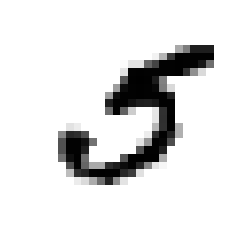

In [30]:
# Vamos a tomar una imagen cualquiera y mostrarla, por ejemplo la 36000. Tomamos su vector X, la escalamos a
# un array de 28*28, y hacemos el plot con imshow.

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [31]:
# Tiene pinta de ser un 5, y lo comprobamos viendo su label

y[36000]

5

In [32]:
# Antes de empezar a trabajar con el dataset debemos separar el training set del test set.
# MNIST ya viene preparado para ello, las primeras 60.000 imagenes para training y las 10.000 restantes test.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [33]:
# Deberíamos también mezclar los datos para que los folds de cross-validation sean similares y no falten dígitos

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [35]:
# Clasificador Binario

# Vamos a simplificar primero el problema, entrenando un sistema que detecte si un dígito es un 5 o no lo es.
# Primero creamos los vectores objetivo para esta tarea de clasificación

y_train_5 = (y_train == 5) # Verdadero para los 5s, falso para todos los demás
y_test_5 = (y_test == 5)

In [36]:
# SGD Classifier
# Un buen lugar para empezar es un 'Stochastic Gradient Descent Classifier', usando las herramientas de 
# Scikit-Learn. Este clasificador es capaz de manejar muchos datos de forma eficaz. Lo entrenaremos con todo el
# training set, con 'random_state' fijo a 42 ya que si no sería aleatorio, así siempre nos sale lo mismo. Los
# parámetros max_iter y tol son relativamente nuevos, así que añadimos estos valores para que cuadren con el libro

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

# Predecimos la imagen que vimos antes

sgd_clf.predict([some_digit])

# Nos da true, con lo que la identifica como un 5. Parece que ha funcionado correctamente, así que evaluaremos 
# el rendimiento del modelo.

array([ True])

In [37]:
# Mediciones de Rendimiento

# Cross-Validation
# cross_val_score con 3 folds.

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

# Parece que sale un "accuracy" altísimo, pero esto se debe a que hay muchas imágenes que no son 5. Por ello
# la medida de "accuracy" no es la medida preferida para los clasificadores. Especialmente en los datasets
# 'skewed', es decir, cuando unas clases son mucho más frecuentes que otras

array([0.90775, 0.96365, 0.96965])

In [38]:
# NOTA
# En ocasiones necesitamos más control que el que nos proporciona cross_val_score. Para ello podemos usar esto:
#
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = (y_train_5[train_index])
#     X_test_fold = X_train[test_index]
#     y_test_fold = (y_train_5[test_index])

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

In [41]:
# Matriz de Confusión

# Una forma mucho mejor de evaluar el comportamiento de un clasificador es mirar la matriz de confusión.
# La idea general es contar el número de veces que una instancia de clase A es clasificada como clase B.
# Por ejemplo, para saber el número de veces que el clasificador confundió imágenes de 5s con 3s, tienes que
# mirar en la quinta fila y tercera columna de la matriz de confusión.

# Para calcular la matriz de confusión, primero necesitamos un set de predicciones, para que puedan compararse
# con los objetivos. Se podrían hacer predicciones en el test set pero por ahora lo vamos a dejar sin tocar.
# En su lugar vamos a usar la función cross_val_predict()

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# Es parecida a cross_val_score() pero en lugar de devolver los evaluation scores, devuelve las predicciones
# hechas en cada test fold
# Ahora ya se puede crear la matriz de confusión

confusion_matrix(y_train_5, y_train_pred)

# Cada fila de la matriz representa una 'actual class', mientras cada columna representa una 'predicted class'.
# La primera fila considera imágenes que no son 5 (la clase negativa). 52422 fueron clasificadas correctamente
# como no-5s (true negatives), mientras que 2157 fueron erróneamente clasificados como 5s (false positives).
# La segunda fila considera imágenes que son 5s (la clase positiva). 1022 fueron clasificadas erróneamente
# como no-5s (false negatives), mientras que los 4399 restantes fueron clasificados correctamente como 5s
# (true positives). Un clasificador perfecto solo tendría true positives y true negatives, por lo que los valores
# fuera de la diagonal principal serán cero.

array([[52422,  2157],
       [ 1022,  4399]])

In [46]:
# Aunque la matriz de confusión nos da información muy valiosa, a veces puede que queramos otras métricas. 
# Para ello tenemos 'precision' y 'recall', incluidas en Scikit-Learn.

print(precision_score(y_train_5, y_train_pred)) # 4399/ (4399 + 2157) # TP/(TP+FP)

print(recall_score(y_train_5, y_train_pred)) # 4399/ (4399 + 1022) # TP/(TP+FN)

# Esto significa que cuando el predictor dice que es un 5, sólo es correcto el 67% de las veces, y que nuestro
# predictor detecta el 81% de los 5s

0.6709884075655888
0.811473897804833


In [49]:
# Es recomendable también combinar precision y recall en una única métrica llamada F1 score. Es una media
# armónica de precision y recall, lo que significa que da mucho peso a valores bajos. Por lo tanto sólo se
# obtendrá un valor alto de F1 score si recall y precision son altos.

# F1 = 2 / ((1/Prec) + (1/Rec))

f1_score(y_train_5, y_train_pred)

# Esta métrica favorece a clasificadores que tengan similar precision y recall, pero a veces eso no es lo que
# queremos. Por ejemplo, si estamos entrenando un clasificador para decidir si ciertos vídeos son aptos para
# niños, preferiremos que se descarten videos adecuados (bajo recall) pero los que se quede sean adecuados
# (alta precisión), antes que tener un recall alto pero que se dejen pasar algunos videos no muy aptos. En estos
# casos incluso se puede querer tener un pipeline humano para supervisar.
# Por otro lado, si tenemos un clasificador para detectar ladrones en cámaras de seguridad, nos parecerá bien si
# tenemos un 30% de precisión pero un 99% de recall (se tendrán algunas falsas alertas pero casi todos los 
# ladrones se pillarán)
# Por desgracia no se pueden tener ambas, mejorar la precisión reduce el recall y viceversa, esto se llama 
# Precision/Recall Tradeof

0.734574601319195

In [51]:
# Precision/Recall Tradeof
# SGDClassifier hace las predicciones asignando un score a cada instancia y comparándolo con un umbral decide
# si es verdadero o falso. Scikit-Learn no nos deja fijar directamente el umbral, pero nos da acceso a los
# decision scores que usa para hacer predicciones. decision_function() devuelve un score para cada instancia.
# Luego podemos fijar un umbral y hacer predicciones en base a ello.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[18759.2767421]
[ True]


In [52]:
# SGDClassifier usa un umbral 0, por lo que el código anterior devuelve lo mismo que predict()
# Subamos el umbral

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# Subir el umbral baja el recall, la imagen es un 5 pero el clasificador falla si subimos el umbral a 200000.

[False]


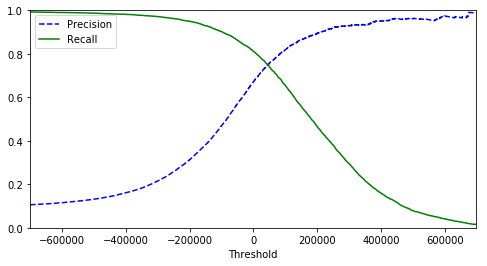

In [56]:
# ¿Entonces cómo podemos decidir el umbral que utilizar?
# Primero debo sacar todos los scores de las instancias del training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

# Con estos scores podemos computar precision y recall para todos los posibles umbrales

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Finalmente representamos precision y recall en función del umbral

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

# De aquí podríamos seleccionar el umbral que nos interese según porcentajes de Precision y Recall

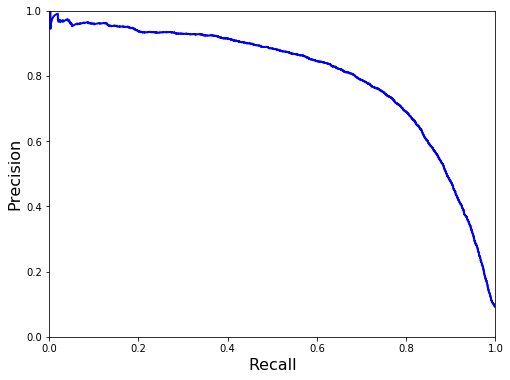

In [57]:
# Otra ayuda puede ser representar precision vs recall (PR)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Vemos una caida abrupta en torno al 80% de recall.
# Un buen clasificador tendrá esta curva lo más pegado posible arriba a la derecha.

In [63]:
# Supongamos que decidimos un 90% de precision. Haciendo zoom en el primer plot veriamos que le corresponde un
# umbral de aproximadamente 200000. Hagamos predicciones de otra forma, sin usar predict().

y_train_pred_90 = (y_scores > 200000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8935643564356436
0.4661501567976388


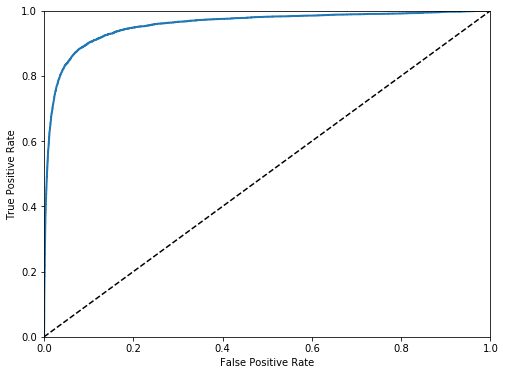

In [66]:
# Curva ROC - Receiver Operating Characteristic

# Parecida a la curva precision/recall, pero hace plot del true positive rate (recall) vs false positive rate.
# FPR: Ratio de negativos que son incorrectamente clasificados como positivos. (1 - True negative rate)
# TNR: Ratio de negativos correctamente clasificados como negativos (specificity)
# Entonces ROC representa sensitivity (recall) vs (1 - specificity)

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# plot FPR vs TPR

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Volvemos a tener tradeoff: a mayor recall (TPR), más falsos positivos (FPR) se producen. La linea de puntos
# representa la curva ROC de un clasificador puramente aleatorio. Un buen clasificador se aleja tanto como sea
# posible de esa línea, arriba a la izquierda.

In [68]:
# Una forma de comparar clasificadores es medir el área bajo la curva (AUC). Un clasificador perfecto tendrá 
# ROC AUC igual a 1. Un clasificador puramente aleatorio tendrá un ROC AUC igual a 0.5

roc_auc_score(y_train_5, y_scores)

# Como la curva ROC es parecida a la Precision/Recall (PR), para decidir cual usar podemos aplicar lo siguiente:
# Preferimos PR si la positive class es rara o si te preocupan más los falsos positivos que los falsos negativos,
# y la curva ROC a la inversa.
# Por ejemplo, mirando la curva ROC anterior, y el score ROC AUC, podríamos pensar que el clasificador es 
# realmente bueno, pero esto es porque hay pocos positivos (5s) comparado con los negativos (no-5s). En cambio, 
# la curva PR deja claro que el clasificador tiene posibilidades de mejora, la curva debería estar más pegada
# arriba a la derecha.

0.9567793160707978

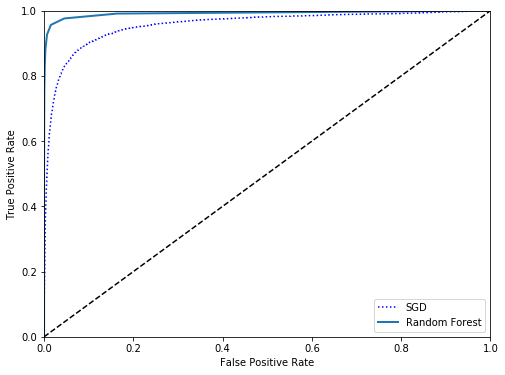

0.9917875474301439

In [74]:
# Entrenemos un Random Forest Classifier y comparemos su curva ROC y el ROC AUC score con el SGDClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")

# Esto nos da probabilidades, pero necesitamos scores para la ROC.

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Ahora sí estamos listos para plotear la curva ROC. Haremos el plot de la primera ROC también para compararlas

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

# Podemos ver que el Random Forest tiene una curva ROC con mucho mejor pinta que la del SGD, se va mucho más
# arriba a la izquierda. En consecuencia, ROC AUC debe ser significativamente mejor.

roc_auc_score(y_train_5, y_scores_forest)

In [75]:
# Mostramos precision score y recall score, 98.2% y 82.7%, no parece mal resultado.

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))

print(recall_score(y_train_5, y_train_pred_forest))

0.982686828840675
0.8271536616860358
